
Multiclass Object Classification using the KITTI Dataset
Models in this script:
1. ResNet-50
2. EfficientNetB0
3. MobileNetV2

This script includes:
- Kaggle API setup and dataset download
- Data Loading and Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Training the models
- Evaluating the models
- Annotating outputs
- Saving models


In [20]:
# Import Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ignore warnings (optional)
import warnings
warnings.filterwarnings('ignore')

In [27]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rujutasharaddabke","key":"52a989f720ae700e5bbd1c417bbcc414"}'}

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [29]:
!ls ~/.kaggle/

kaggle.json


In [31]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set proper permissions
!mv ~/.kaggle/kaggle.json /root/.config/kaggle/ #Move the file to correct location for Kaggle API

Download the KITTI dataset using Kaggle API

In [32]:
# Import Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate the API
api = KaggleApi()
api.authenticate()

dataset_name = 'garymk/kitti-3d-object-detection-dataset'
dataset_path = '/content/kitti_dataset/'

# Check if the dataset directory exists
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    # Download the dataset
    !kaggle datasets download -d {dataset_name} -p {dataset_path}
    # Unzip the dataset
    !unzip -q {dataset_path}kitti-3d-object-detection-dataset.zip -d {dataset_path}
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/garymk/kitti-3d-object-detection-dataset
License(s): unknown
100% 30.0G/30.0G [04:01<00:00, 154MB/s]
100% 30.0G/30.0G [04:01<00:00, 134MB/s]
Dataset downloaded and extracted successfully.


In [33]:
# Data Acquisition and Loading

# Define the paths to the data directories
image_dir = os.path.join(dataset_path, 'training/image_2/')
label_dir = os.path.join(dataset_path, 'training/label_2/')

# Get a list of all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

Data Exploration (EDA) and Preprocessing

In [34]:
#  Define the class mapping
class_mapping = {
    'Pedestrian': 'Pedestrian',
    'Person_sitting': 'Pedestrian',
    'Cyclist': 'Cyclist',
    'Car': 'Car',
    'Truck': 'Large_Vehicle',
    'Van': 'Large_Vehicle',
    'Tram': 'Large_Vehicle',
    'Misc': 'Miscellaneous',
    'DontCare': None  # Exclude 'DontCare' labels
}

In [35]:
# Initialize lists to store data and labels
images = []
labels = []

In [36]:
# Function to read labels and map classes
def map_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        mapped_classes = []
        for line in lines:
            data = line.strip().split()
            obj_class = data[0]
            mapped_class = class_mapping.get(obj_class)
            if mapped_class is not None:
                mapped_classes.append(mapped_class)
        return mapped_classes

In [37]:
# Load images and labels
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace('.png', '.txt'))

    # Read and preprocess the image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (224, 224))  # Resize to 224x224
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    images.append(image_rgb)

    # Read and map labels
    mapped_classes = map_label(label_path)
    if mapped_classes:
        # For simplicity, we use the first object's class
        labels.append(mapped_classes[0])
    else:
        labels.append('Miscellaneous')  # Default to 'Miscellaneous' if no labels

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Normalize images
X = X / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

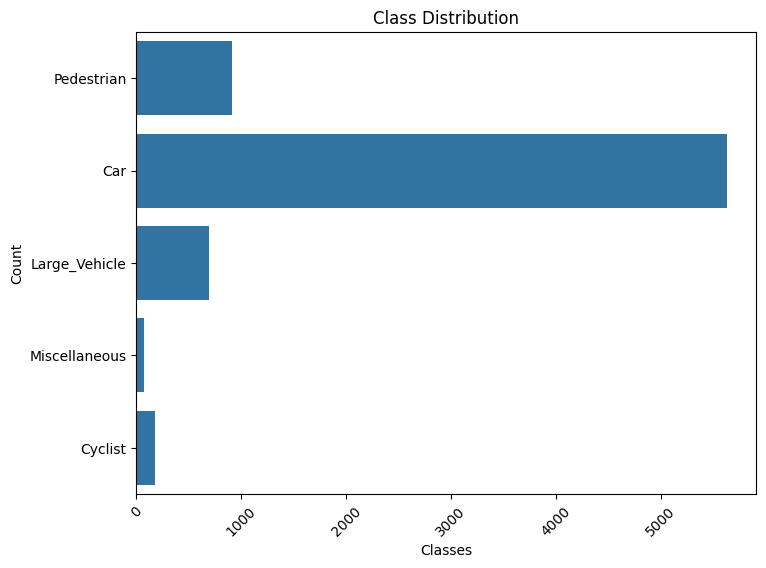

In [38]:
# Visualize Class Distribution
plt.figure(figsize=(8,6))
sns.countplot(y)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


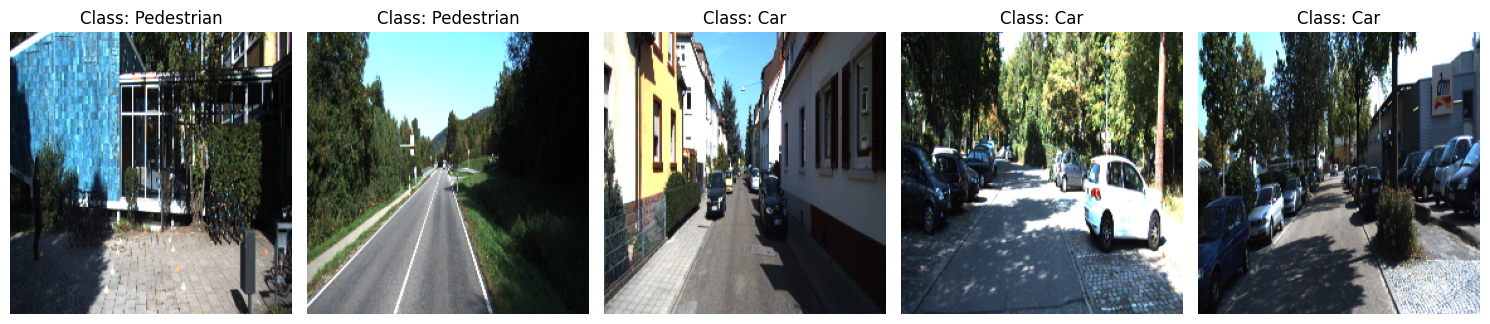

In [39]:
# Display Sample Images with Annotations
def display_sample_images(num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        image = X[idx]
        label = y[idx]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'Class: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images()

In [40]:
# Data Splitting

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [41]:
# Data Augmentation

# Define data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# For validation and test data, we use a simple generator
test_datagen = ImageDataGenerator()


In [42]:
# Model 1 - ResNet-50

# 8.1 Build the model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False  # Freeze the base model

# Add custom layers on top
resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


In [43]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model
resnet_history = resnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=test_datagen.flow(X_val, y_val),
    epochs=10
)

Epoch 1/10
164/164 [==============================] - 112s 664ms/step - loss: 0.8185 - accuracy: 0.7538 - val_loss: 0.7191 - val_accuracy: 0.7585
Epoch 2/10
164/164 [==============================] - 107s 650ms/step - loss: 0.7302 - accuracy: 0.7788 - val_loss: 0.6973 - val_accuracy: 0.8021
Epoch 3/10
164/164 [==============================] - 106s 643ms/step - loss: 0.7362 - accuracy: 0.7863 - val_loss: 0.6905 - val_accuracy: 0.8066
Epoch 4/10
164/164 [==============================] - 108s 655ms/step - loss: 0.6862 - accuracy: 0.8023 - val_loss: 0.6377 - val_accuracy: 0.8075
Epoch 5/10
164/164 [==============================] - 109s 663ms/step - loss: 0.6778 - accuracy: 0.8031 - val_loss: 0.6192 - val_accuracy: 0.8137
Epoch 6/10
164/164 [==============================] - 107s 653ms/step - loss: 0.6583 - accuracy: 0.8094 - val_loss: 0.6125 - val_accuracy: 0.8182
Epoch 7/10
164/164 [==============================] - 106s 646ms/step - loss: 0.6558 - accuracy: 0.8117 - val_loss: 0.6137 -

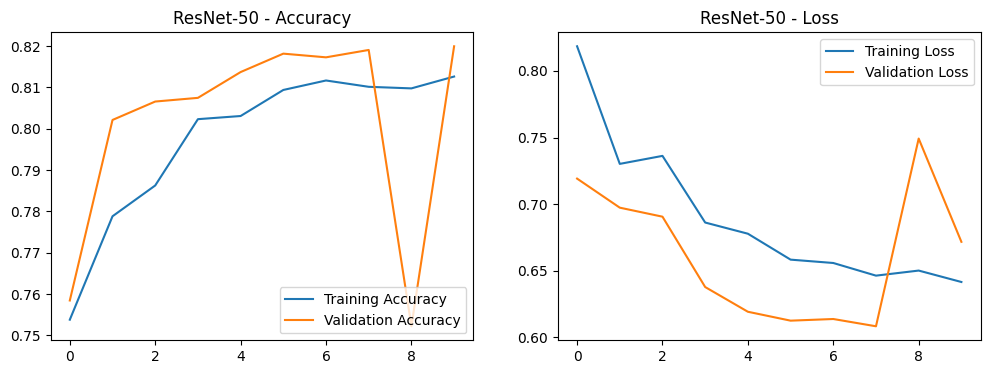

In [45]:
# Plot Training and Validation Accuracy and Loss
def plot_training_history(history, model_name):
    epochs_range = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot training history for ResNet-50
plot_training_history(resnet_history, 'ResNet-50')


In [46]:
# Model 2 - EfficientNetB0

# Build the model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_base.trainable = False

# Add custom layers
efficientnet_model = models.Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


16705208/16705208 [==============================] - 0s 0us/step


In [47]:
# Compile the model
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/10
164/164 [==============================] - 89s 505ms/step - loss: 0.8542 - accuracy: 0.7529 - val_loss: 0.8346 - val_accuracy: 0.7531
Epoch 2/10
164/164 [==============================] - 81s 494ms/step - loss: 0.8537 - accuracy: 0.7529 - val_loss: 0.8345 - val_accuracy: 0.7531
Epoch 3/10
164/164 [==============================] - 82s 497ms/step - loss: 0.8366 - accuracy: 0.7529 - val_loss: 0.8341 - val_accuracy: 0.7531
Epoch 4/10
164/164 [==============================] - 81s 492ms/step - loss: 0.8448 - accuracy: 0.7529 - val_loss: 0.8291 - val_accuracy: 0.7531
Epoch 5/10
164/164 [==============================] - 81s 492ms/step - loss: 0.8316 - accuracy: 0.7529 - val_loss: 0.8353 - val_accuracy: 0.7531
Epoch 6/10
164/164 [==============================] - 81s 495ms/step - loss: 0.8285 - accuracy: 0.7529 - val_loss: 0.8356 - val_accuracy: 0.7531
Epoch 7/10
164/164 [==============================] - 82s 497ms/step - loss: 0.8325 - accuracy: 0.7529 - val_loss: 0.8265 - val_ac

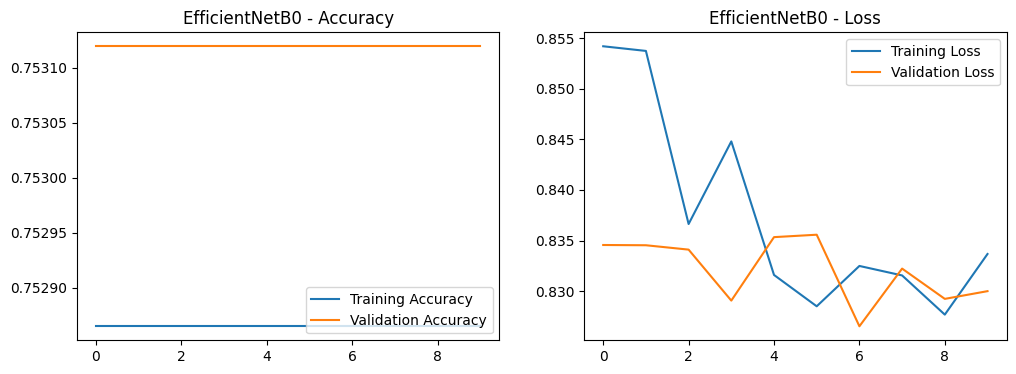

In [48]:
# Train the model
efficientnet_history = efficientnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=test_datagen.flow(X_val, y_val),
    epochs=10
)

# Plot training history for EfficientNetB0
plot_training_history(efficientnet_history, 'EfficientNetB0')

In [49]:
# Model 3 - MobileNetV2

# Build the model
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base.trainable = False

# Add custom layers
mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [50]:
# Compile the model
mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/10
164/164 [==============================] - 70s 412ms/step - loss: 0.5624 - accuracy: 0.8428 - val_loss: 0.4929 - val_accuracy: 0.8467
Epoch 2/10
164/164 [==============================] - 67s 405ms/step - loss: 0.3972 - accuracy: 0.8816 - val_loss: 0.4102 - val_accuracy: 0.8601
Epoch 3/10
164/164 [==============================] - 67s 405ms/step - loss: 0.3397 - accuracy: 0.8946 - val_loss: 0.3588 - val_accuracy: 0.8797
Epoch 4/10
164/164 [==============================] - 66s 403ms/step - loss: 0.3098 - accuracy: 0.9064 - val_loss: 0.3859 - val_accuracy: 0.8824
Epoch 5/10
164/164 [==============================] - 66s 403ms/step - loss: 0.2781 - accuracy: 0.9131 - val_loss: 0.3259 - val_accuracy: 0.9046
Epoch 6/10
164/164 [==============================] - 67s 405ms/step - loss: 0.2615 - accuracy: 0.9154 - val_loss: 0.3421 - val_accuracy: 0.8913
Epoch 7/10
164/164 [==============================] - 66s 403ms/step - loss: 0.2318 - accuracy: 0.9263 - val_loss: 0.3364 - val_ac

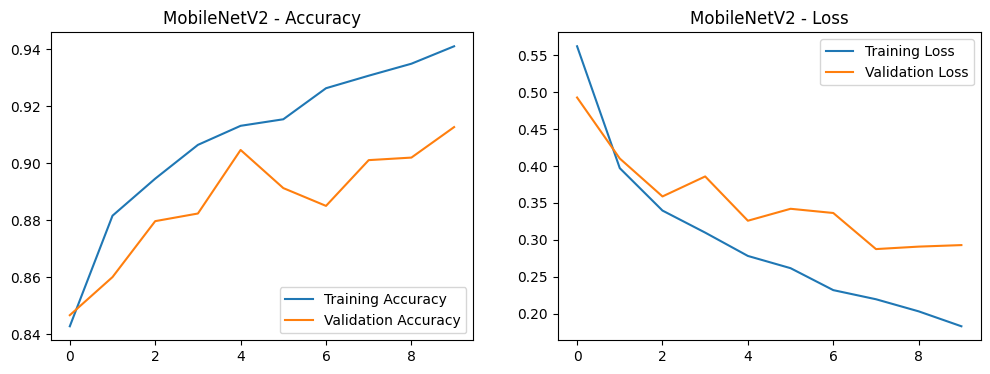

In [51]:
# Train the model
mobilenet_history = mobilenet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=test_datagen.flow(X_val, y_val),
    epochs=10
)

# Plot training history for MobileNetV2
plot_training_history(mobilenet_history, 'MobileNetV2')

In [52]:
# Evaluate Models and Annotate Outputs

def evaluate_and_annotate(model, model_name):
    """
    Evaluates the model on the test set and annotates sample outputs.
    """
    # Evaluate the model
    test_steps = X_test.shape[0] // 32 + 1
    loss, accuracy = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=32), steps=test_steps)
    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    # Generate predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Annotate sample images with predictions
    plt.figure(figsize=(15, 5))
    for i in range(5):  # Annotate first 5 test images
        image = X_test[i]
        true_label = class_names[y_test[i]]
        predicted_label = class_names[y_pred[i]]
        confidence = np.max(y_pred_probs[i])

        # Add annotation
        label_text = f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"

        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(label_text)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



36/36 [==============================] - 19s 520ms/step - loss: 0.6588 - accuracy: 0.8183
ResNet-50 Test Accuracy: 81.83%
36/36 [==============================] - 19s 517ms/step
Classification Report for ResNet-50:
               precision    recall  f1-score   support

          Car       0.83      0.97      0.89       845
      Cyclist       1.00      0.08      0.14        26
Large_Vehicle       0.00      0.00      0.00       104
Miscellaneous       0.00      0.00      0.00        11
   Pedestrian       0.74      0.72      0.73       137

     accuracy                           0.82      1123
    macro avg       0.51      0.35      0.35      1123
 weighted avg       0.74      0.82      0.76      1123



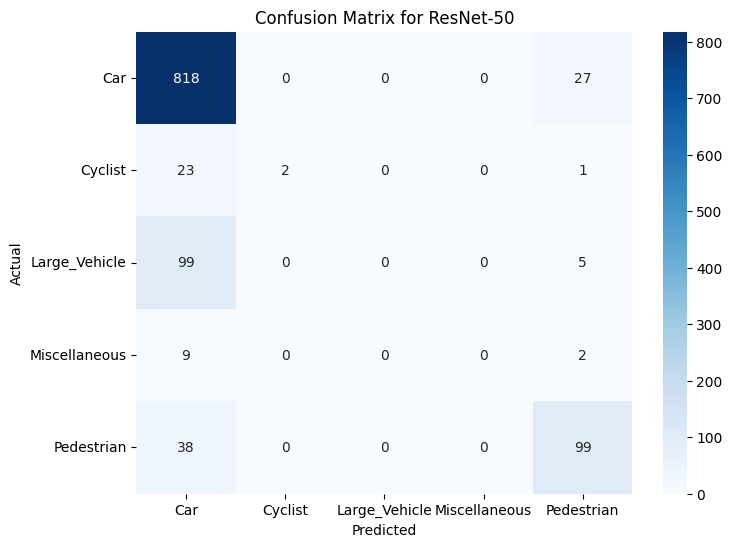

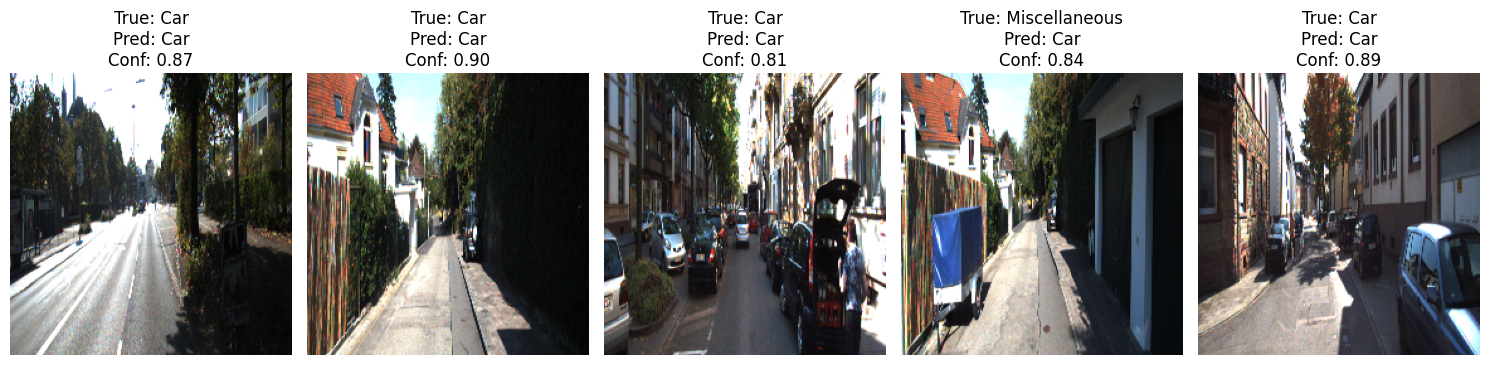

In [55]:
# Evaluate and annotate outputs for each model
evaluate_and_annotate(resnet_model, 'ResNet-50')

36/36 [==============================] - 12s 328ms/step - loss: 0.8291 - accuracy: 0.7524
EfficientNetB0 Test Accuracy: 75.24%
36/36 [==============================] - 12s 324ms/step
Classification Report for EfficientNetB0:
               precision    recall  f1-score   support

          Car       0.75      1.00      0.86       845
      Cyclist       0.00      0.00      0.00        26
Large_Vehicle       0.00      0.00      0.00       104
Miscellaneous       0.00      0.00      0.00        11
   Pedestrian       0.00      0.00      0.00       137

     accuracy                           0.75      1123
    macro avg       0.15      0.20      0.17      1123
 weighted avg       0.57      0.75      0.65      1123



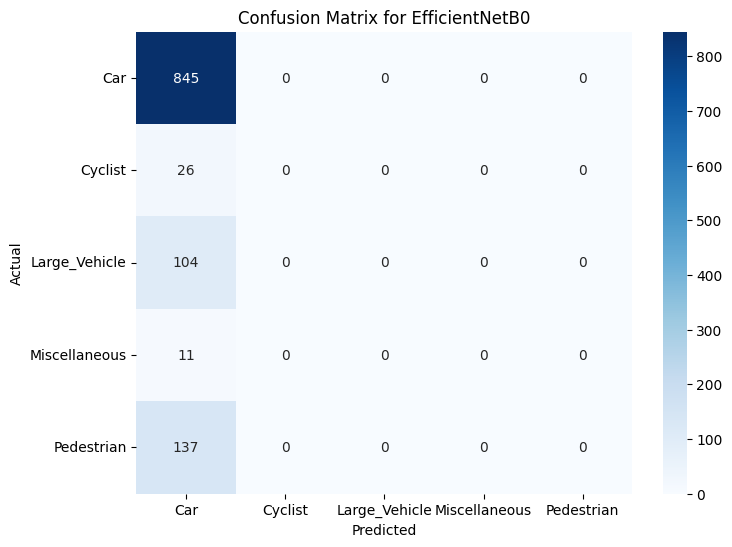

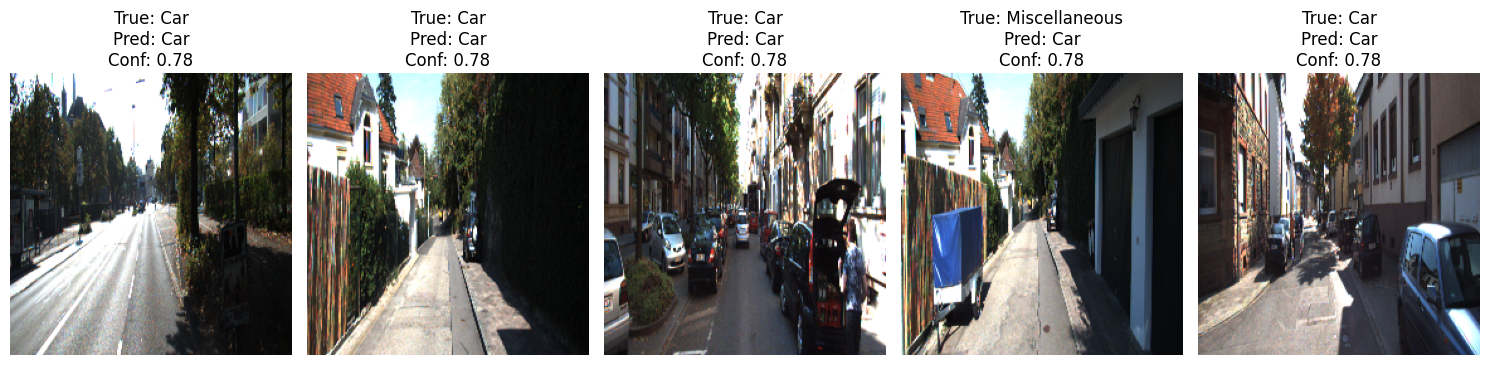

In [56]:
evaluate_and_annotate(efficientnet_model, 'EfficientNetB0')

36/36 [==============================] - 8s 207ms/step - loss: 0.2898 - accuracy: 0.9029
MobileNetV2 Test Accuracy: 90.29%
36/36 [==============================] - 7s 190ms/step
Classification Report for MobileNetV2:
               precision    recall  f1-score   support

          Car       0.92      0.95      0.94       845
      Cyclist       0.78      0.27      0.40        26
Large_Vehicle       0.68      0.75      0.72       104
Miscellaneous       0.70      0.64      0.67        11
   Pedestrian       0.98      0.85      0.91       137

     accuracy                           0.90      1123
    macro avg       0.81      0.69      0.73      1123
 weighted avg       0.90      0.90      0.90      1123



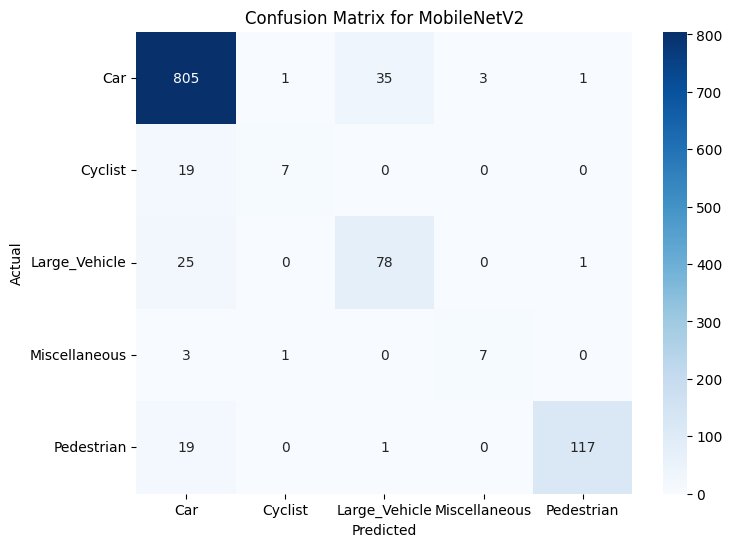

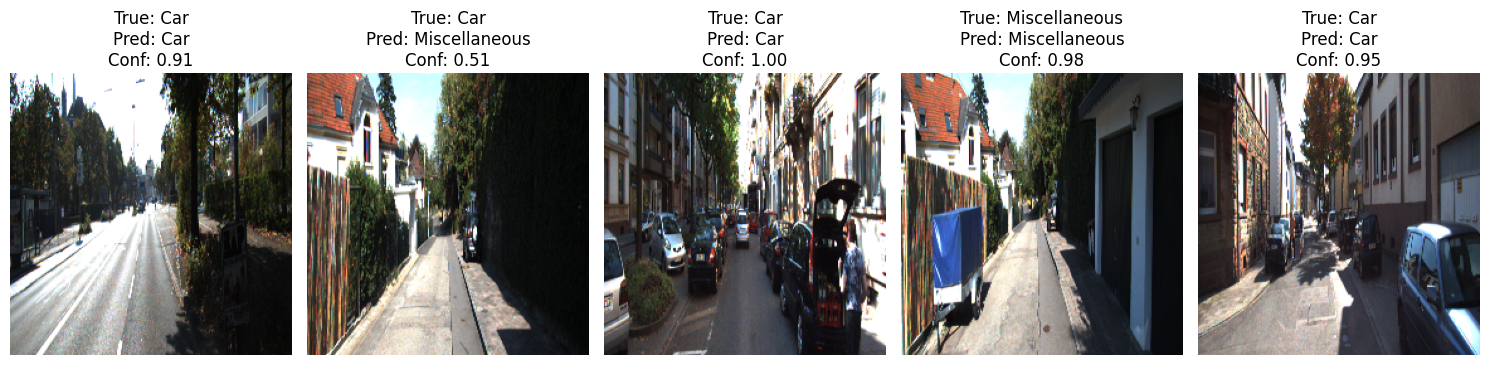

In [57]:
evaluate_and_annotate(mobilenet_model, 'MobileNetV2')

In [59]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [60]:
# Rebalance Classes Using Class Weights
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")


Class Weights: {0: 0.2656519533231862, 1: 8.654545454545454, 2: 2.1726141078838173, 3: 19.758490566037736, 4: 1.6413793103448275}


In [61]:
# Fine-Tune MobileNetV2
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [62]:
# Unfreeze all layers for fine-tuning
mobilenet_base.trainable = True

In [63]:
# Add custom classification layers
mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [64]:
# Compile the model with a lower learning rate
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
# Train the Model with Fine-Tuning
fine_tune_epochs = 15  # Increase the number of epochs for fine-tuning
mobilenet_history = mobilenet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=test_datagen.flow(X_val, y_val),
    epochs=fine_tune_epochs,
    class_weight=class_weights
)

Epoch 1/15
164/164 [==============================] - 161s 912ms/step - loss: 1.2083 - accuracy: 0.4696 - val_loss: 0.8326 - val_accuracy: 0.6355
Epoch 2/15
164/164 [==============================] - 142s 866ms/step - loss: 0.6356 - accuracy: 0.6881 - val_loss: 1.0094 - val_accuracy: 0.5508
Epoch 3/15
164/164 [==============================] - 143s 869ms/step - loss: 0.4504 - accuracy: 0.7634 - val_loss: 0.8065 - val_accuracy: 0.6791
Epoch 4/15
164/164 [==============================] - 144s 879ms/step - loss: 0.3616 - accuracy: 0.8174 - val_loss: 0.6363 - val_accuracy: 0.7692
Epoch 5/15
164/164 [==============================] - 145s 884ms/step - loss: 0.2908 - accuracy: 0.8466 - val_loss: 0.5948 - val_accuracy: 0.7923
Epoch 6/15
164/164 [==============================] - 145s 880ms/step - loss: 0.2274 - accuracy: 0.8739 - val_loss: 0.4206 - val_accuracy: 0.8529
Epoch 7/15
164/164 [==============================] - 143s 869ms/step - loss: 0.2121 - accuracy: 0.8942 - val_loss: 0.4156 -

36/36 [==============================] - 6s 175ms/step - loss: 0.3582 - accuracy: 0.8940
Fine-Tuned MobileNetV2 Test Accuracy: 89.40%
36/36 [==============================] - 9s 181ms/step
Classification Report for Fine-Tuned MobileNetV2:
               precision    recall  f1-score   support

          Car       0.99      0.88      0.93       845
      Cyclist       0.88      0.88      0.88        26
Large_Vehicle       0.55      0.91      0.69       104
Miscellaneous       0.77      0.91      0.83        11
   Pedestrian       0.85      0.99      0.91       137

     accuracy                           0.89      1123
    macro avg       0.81      0.91      0.85      1123
 weighted avg       0.92      0.89      0.90      1123



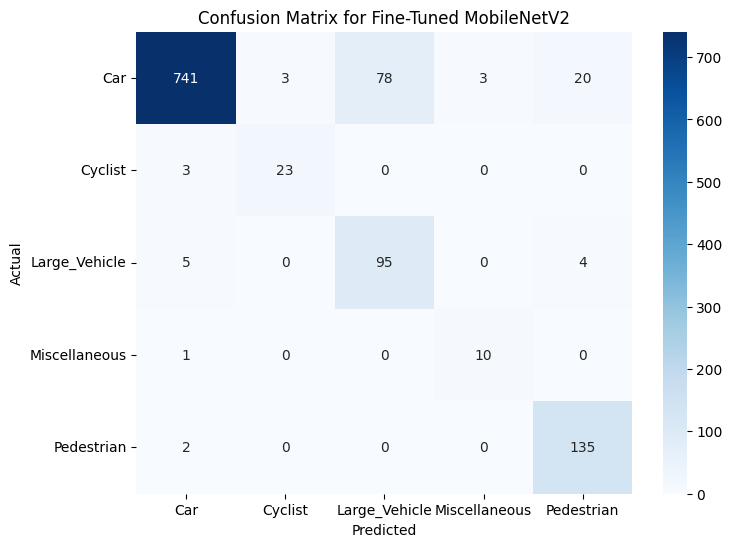

In [66]:
# Evaluate the Fine-Tuned Model
def evaluate_model(model, model_name, X_test, y_test):
    # Evaluate the model
    test_steps = X_test.shape[0] // 32 + 1
    loss, accuracy = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=32), steps=test_steps)
    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    # Generate predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(mobilenet_model, 'Fine-Tuned MobileNetV2', X_test, y_test)


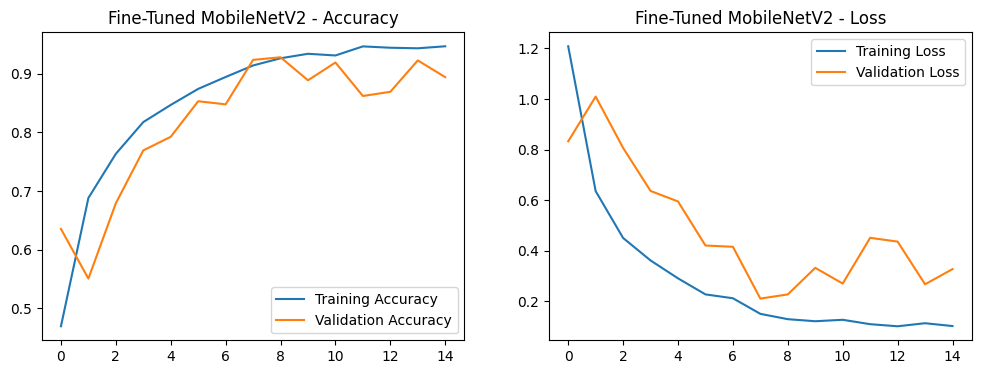

In [67]:
# Visualize Training and Validation Performance
def plot_training_history(history, model_name):
    epochs_range = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

plot_training_history(mobilenet_history, 'Fine-Tuned MobileNetV2')



In [68]:
# Save the Fine-Tuned Model
mobilenet_model.save('fine_tuned_mobilenetv2.h5')
print("Fine-tuned MobileNetV2 model saved as 'fine_tuned_mobilenetv2.h5'")

Fine-tuned MobileNetV2 model saved as 'fine_tuned_mobilenetv2.h5'


In [54]:
# Save Models

resnet_model.save('resnet50_model.h5')
efficientnet_model.save('efficientnetb0_model.h5')
mobilenet_model.save('mobilenetv2_model.h5')

In [70]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [71]:
import os

# Specify the directory in Google Drive
save_dir = '/content/drive/My Drive/Trained_Models_part1/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [72]:
# Save ResNet-50
resnet_model.save(os.path.join(save_dir, 'resnet50_model.h5'))

# Save EfficientNetB0
efficientnet_model.save(os.path.join(save_dir, 'efficientnetb0_model.h5'))

# Save MobileNetV2
mobilenet_model.save(os.path.join(save_dir, 'mobilenetv2_model.h5'))

# Save Fine-Tuned MobileNetV2
mobilenet_model.save(os.path.join(save_dir, 'fine_tuned_mobilenetv2.h5'))

print("Models saved to Google Drive.")


Models saved to Google Drive.


In [73]:
# List files in the save directory
saved_files = os.listdir(save_dir)
print("Saved Models:", saved_files)


Saved Models: ['resnet50_model.h5', 'efficientnetb0_model.h5', 'mobilenetv2_model.h5', 'fine_tuned_mobilenetv2.h5']


In [74]:
import shutil

# Zip the models directory
shutil.make_archive('/content/drive/My Drive/Trained_Models', 'zip', save_dir)

print("All models compressed and saved as Trained_Models.zip in Google Drive.")


All models compressed and saved as Trained_Models.zip in Google Drive.
